In [28]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os

In [166]:
# Data load and pre-processing
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Dec_8\\"
#oscar_path = "D:\\data\\oscar\\Brest_Sample_Oct_13_2022\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])
file_index = 0 #Process single file from list below
ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
#antenna_ident = ss.utils.tools.antenna_idents(ds)
antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(oscar_path, file_time_triplets[file_index][1])
ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)
print('Processing file index',file_index)

OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Dec_8\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220517T101737 , File list indices : [3, 4, 5]
Processing file index 0


In [164]:
# L1 processing
window = 7
for i in list(ds.keys()):
    ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
    ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window)
    ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
    ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
    ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
    ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
#Build L1 dataset
dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
# Generating geophysical data fields for GMF doppler computation
u10 = 10 # wind speed
wind_direction = 150 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
# Compute RSC
dsl1 = compute_radial_surface_current(dsl1, aux, gmf='mouche12')
#dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1, aux, gmf='mouche12')
#L2 Processing
# Initialise l2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)
# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)
# Compute current vectors
dsl2['CurrentVectorUComponent'], dsl2['CurrentVectorVComponent'] =\
ss.utils.tools.currentVelDir2UV(dsl2['CurrentMagnitude'], dsl2['CurrentDirection'])


In [90]:
# Load Auxiliary data

xband_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(xband_file, dsl2)
ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
compute_Xband_current_magnitude_and_direction(ds_xband)

folder = 'unrestricted\\'
aux_data_folder = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Iframer\\"
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'

F1 = xr.open_dataset(aux_data_folder + folder + list22['F1'])
L1 = xr.open_dataset(aux_data_folder + folder + list22['L1'])
W3 = xr.open_dataset(aux_data_folder + folder + list22['W3'])


cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
L1['CurrentMagnitude'] = (('time','nj','ni'), cvel)
L1['CurrentDirection'] = (('time','nj','ni'), cdir)

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


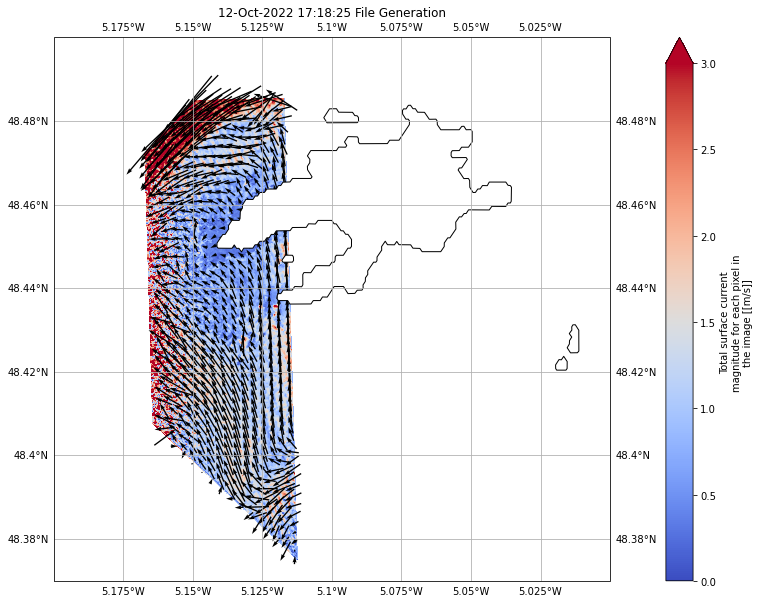

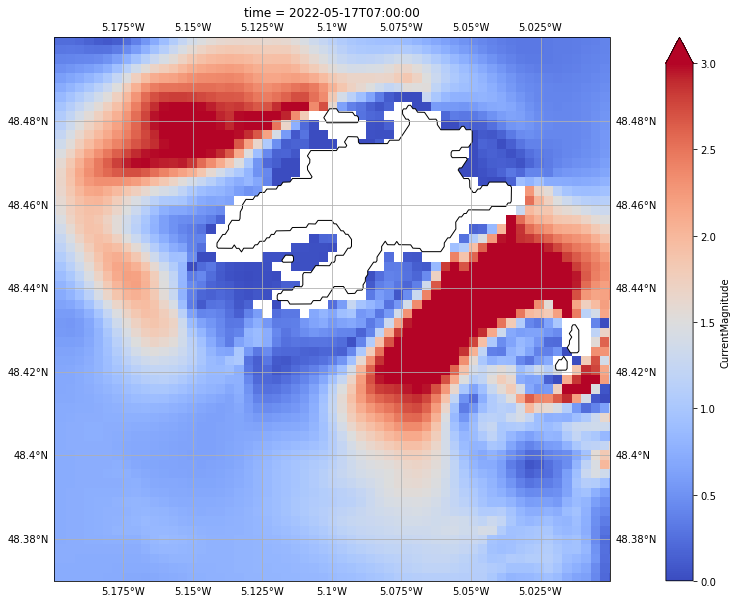

In [165]:
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 10 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree()
)
dsl2\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
#plt.plot((5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()
plt.title(dsl1.attrs['History'])
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.0, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
L1.CurrentMagnitude.isel(time=4)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree()
)

#L1sel=L1.isel(time=4)
#L1sel\
#.plot.quiver(
#    x='longitude',
#    y='latitude',
#    u='U',
#    v='V',
#    scale=30,
#    angles='xy',
#    robust=True,
#    transform=ccrs.PlateCarree()
#)

gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.0, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

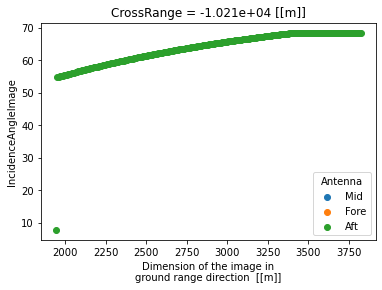

In [66]:
dsl1.isel(CrossRange=100).plot.scatter(x='GroundRange',y='IncidenceAngleImage',hue='Antenna') 

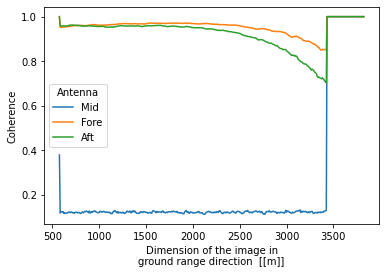

In [141]:
dsl1.Coherence.median(dim='CrossRange').plot(hue='Antenna')

#dsf.SigmaImageAmplitude.median(dim='GroundRange').plot(label='Fore')
#dsa.SigmaImageAmplitude.median(dim='GroundRange').plot(label='Aft')

Text(0.5, 1.0, '07-Dec-2022 16:57:28 File Generation')

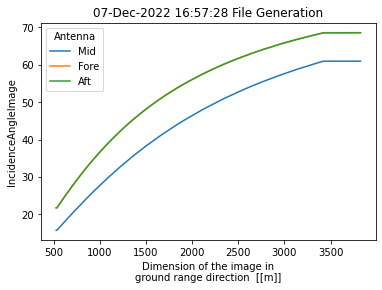

In [161]:
dsl1.IncidenceAngleImage.median(dim='CrossRange').plot(hue='Antenna')
plt.title(dsl1.attrs['History'])

In [157]:
dsl1.attrs['History']

'12-Oct-2022 17:18:25 File Generation'

Text(0.5, 1.0, '12-Oct-2022 17:18:25 File Generation')

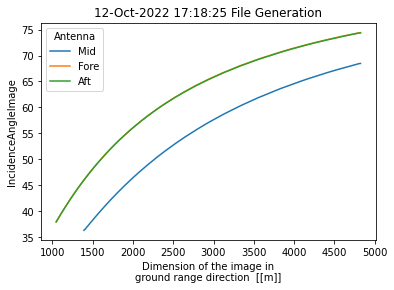

In [158]:
dsl1.IncidenceAngleImage.median(dim='CrossRange').plot(hue='Antenna')
plt.title(dsl1.attrs['History'])

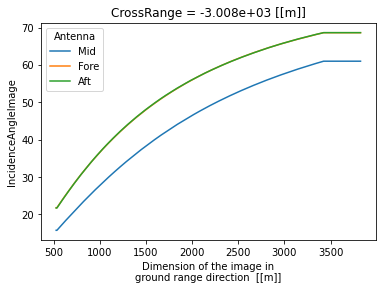

In [151]:
dsl1.isel(CrossRange=1000).IncidenceAngleImage.plot(hue='Antenna')

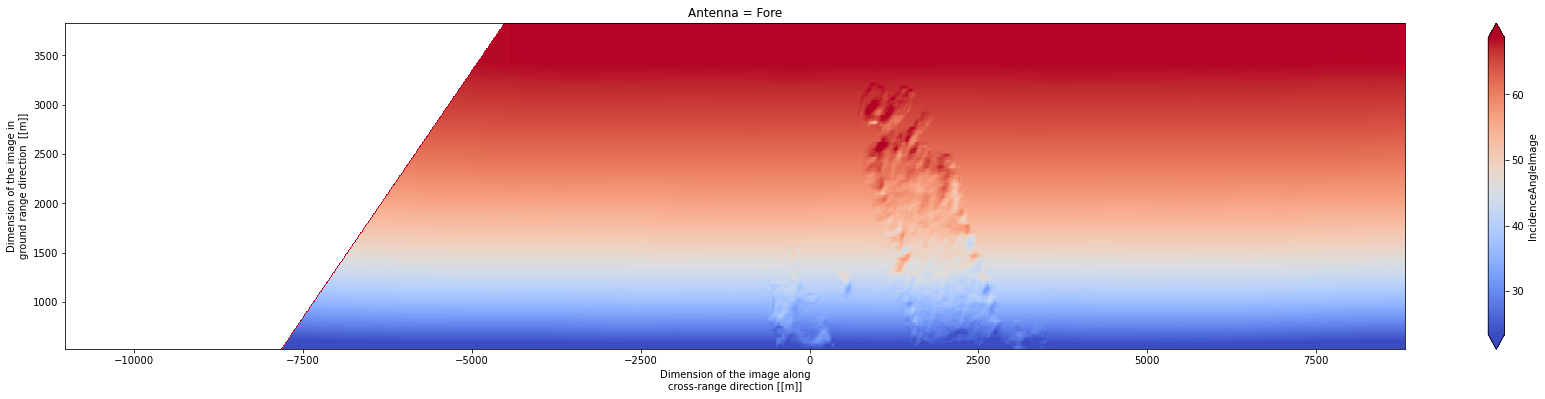

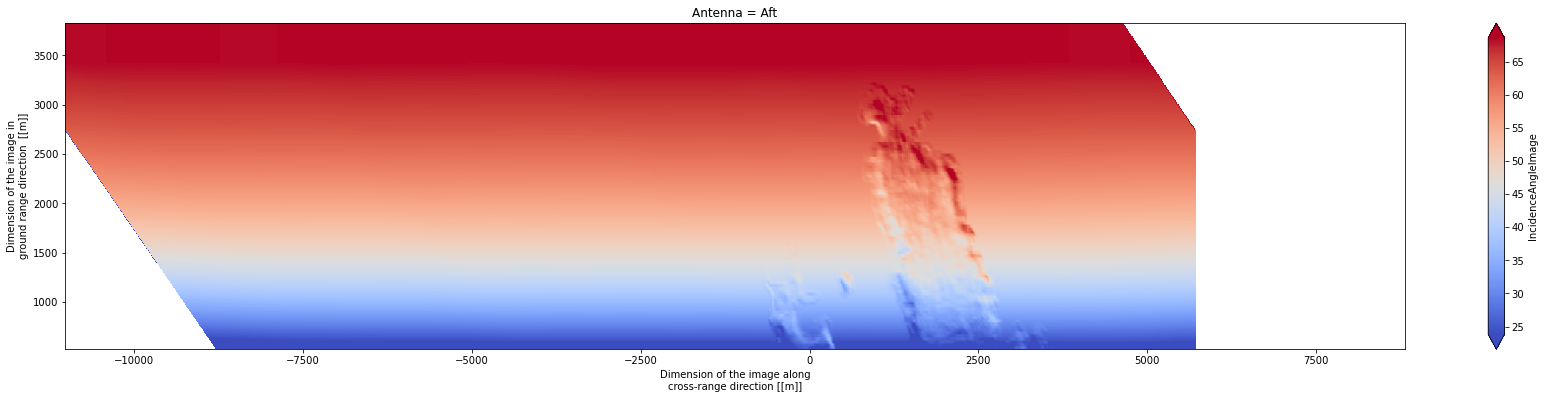

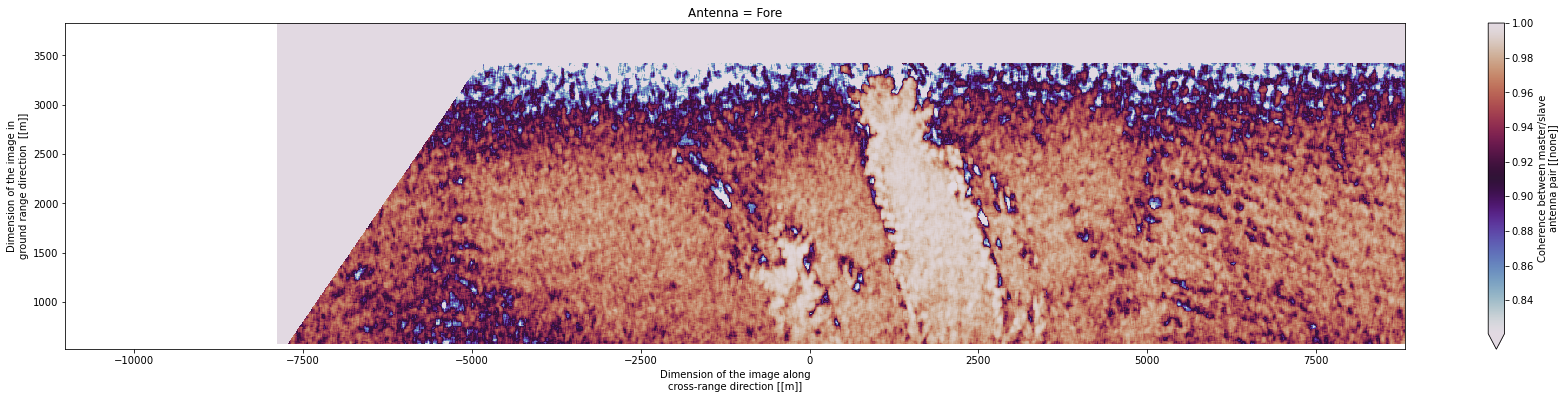

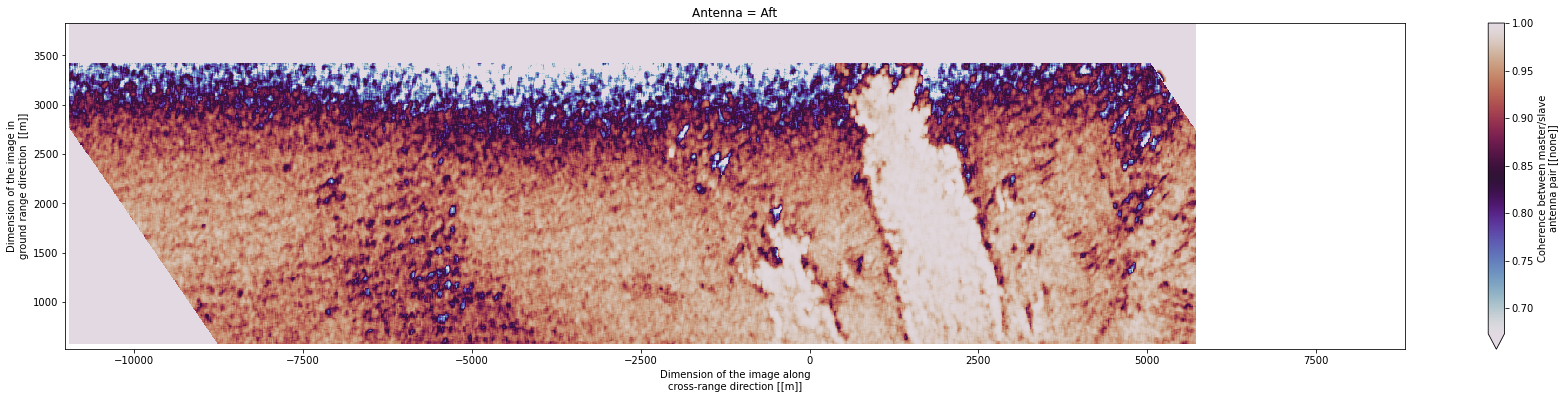

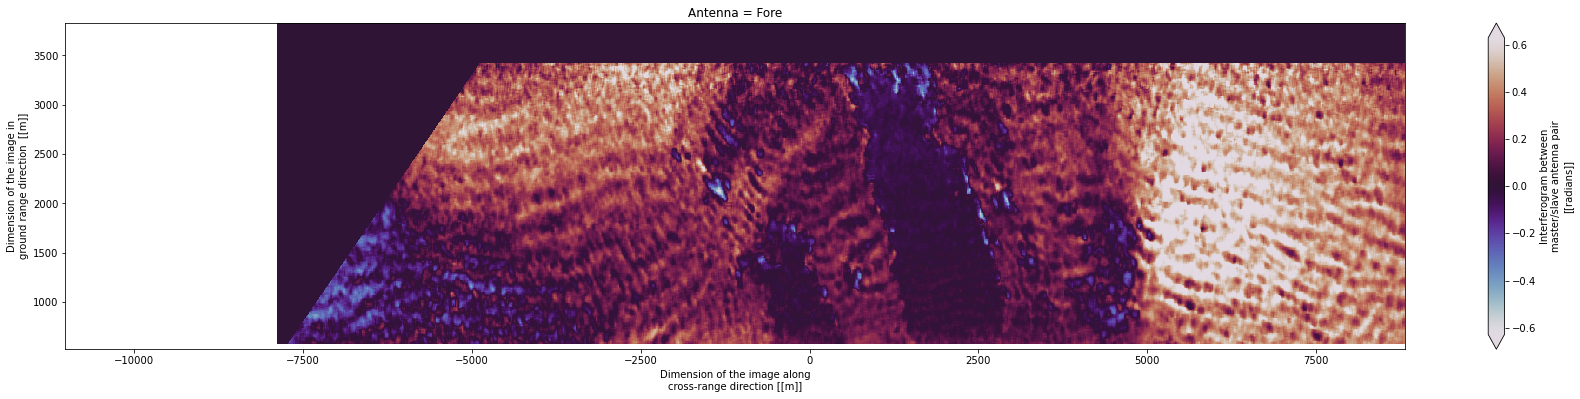

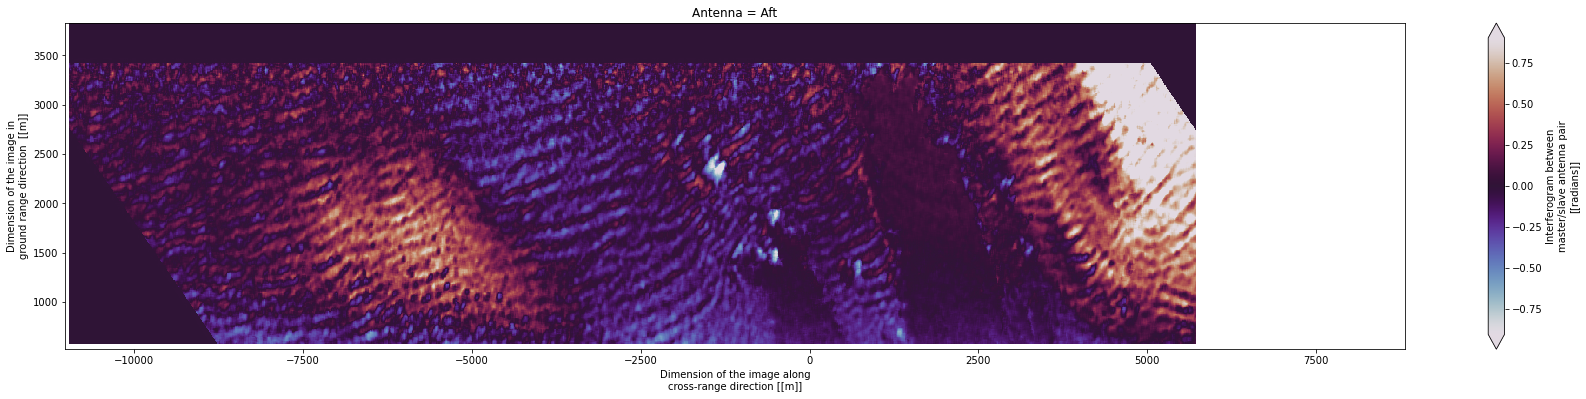

In [136]:
ax3 = dsl1.IncidenceAngleImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.IncidenceAngleImage.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.Coherence.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Coherence.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Interferogram.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Interferogram.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )

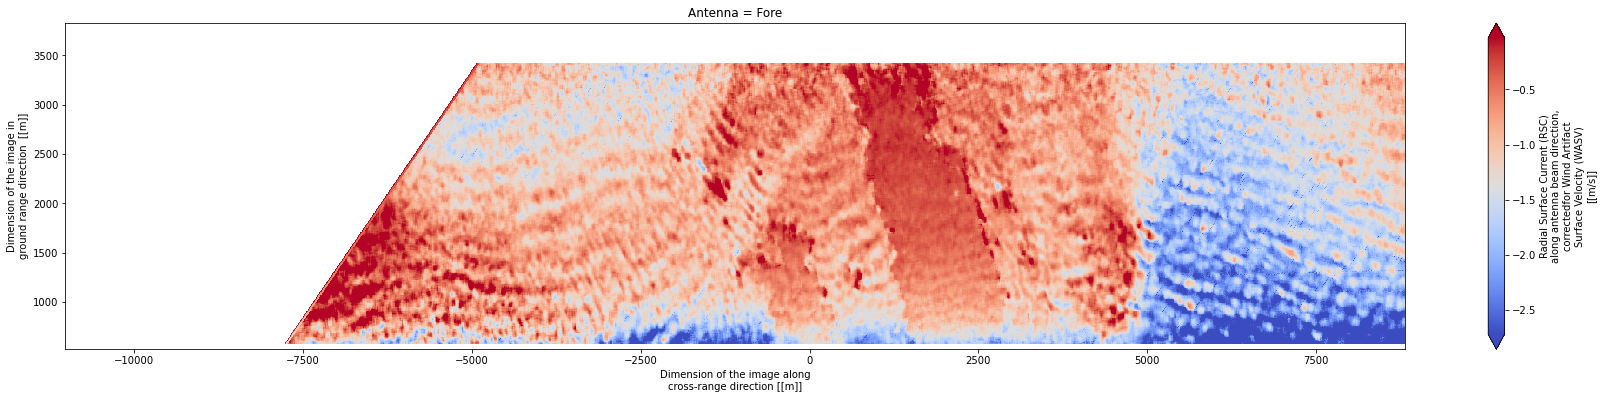

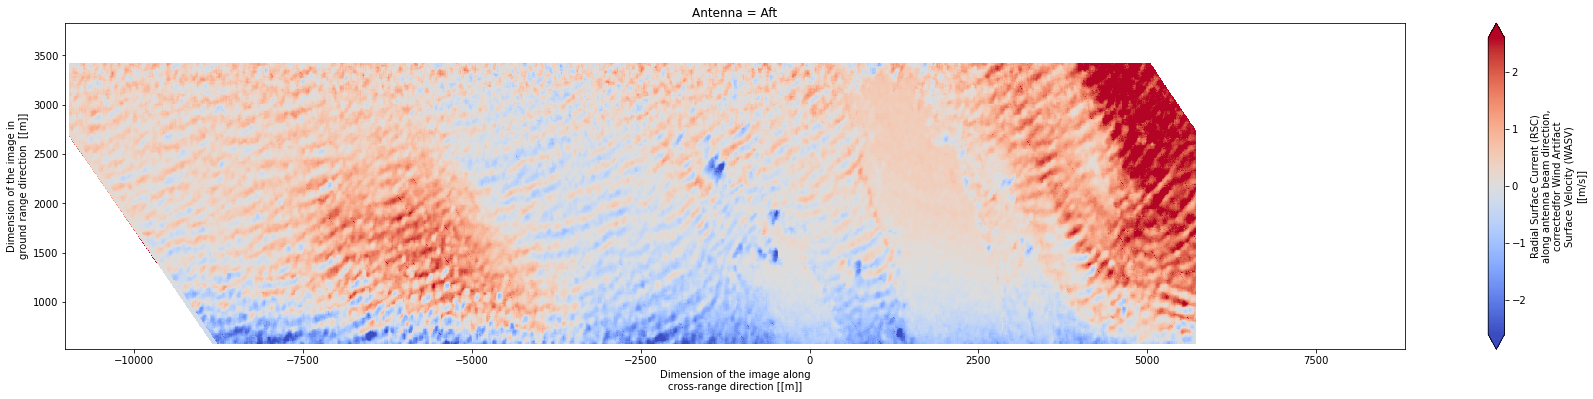

In [135]:
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [17]:
dsl2.latitude

<xarray.DataArray 'latitude' (CrossRange: 6857, GroundRange: 494)>
array([[47.56571727, 47.5657087 , 47.56570013, ..., 47.56149765,
        47.56148903, 47.56148041],
       [47.56564581, 47.56563724, 47.56562867, ..., 47.5614262 ,
        47.56141758, 47.56140897],
       [47.56557436, 47.56556579, 47.56555722, ..., 47.56135475,
        47.56134613, 47.56133752],
       ...,
       [47.07593484, 47.07592634, 47.07591783, ..., 47.07174715,
        47.07173859, 47.07173004],
       [47.07586338, 47.07585487, 47.07584637, ..., 47.07167569,
        47.07166713, 47.07165858],
       [47.07579191, 47.07578341, 47.0757749 , ..., 47.07160422,
        47.07159567, 47.07158712]])
Coordinates:
  * CrossRange   (CrossRange) float64 -2.844e+04 -2.843e+04 ... 2.641e+04
  * GroundRange  (GroundRange) float64 1.072e+03 1.08e+03 ... 5.016e+03
    latitude     (CrossRange, GroundRange) float64 47.57 47.57 ... 47.07 47.07
    longitude    (CrossRange, GroundRange) float64 -4.871 -4.871 ... -4.905
Attributes:
    long_name:  latitude of the pixels in the image
    units:      [deg]

In [81]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv_f = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Fore'),
                                                 aux,
                                                 gmf)
    dswasv_a = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Aft'),
                                                 aux,
                                                 gmf)
    dswasv_m = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Mid'),
                                                 aux,
                                                 gmf)

    level1['RadialSurfaceCurrent'] = xr.concat(
        [level1.RadialSurfaceVelocity.sel(Antenna='Fore') - dswasv_f.WASV,
         -level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv_a.WASV,
         level1.RadialSurfaceVelocity.sel(Antenna='Mid') - dswasv_m.WASV],
        'Antenna', join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent.assign_coords(

    Antenna=('Antenna', list(level1.Antenna.data)))

    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

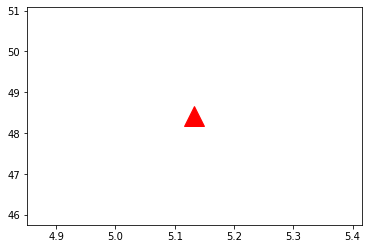

In [125]:
plt.plot(5.13305, 48.4166, marker="^", color='r', markersize=20)